# Introduction

On utilise comme domaine un ensemble de gaussiennes qui forment des creux et des montagnes.  
Les tourbillons vont suivre les isolignes de ce domaine.

# Import

In [1]:
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Variable

In [2]:
N = 2000 #nombre de tourbillons dans le catalogue
obs = 100 #nombre de tourbillons à prédire
N_pred = 20 #nombre de pas de temps sur lequel on va prédire
nb_voisin = 100 #le nombre de voisins choisis
methods = [locally_constant_mean, locally_incremental_mean, locally_linear_mean] #les différentes méthodes possibles
names = ["locally_constant_mean","locally_incremental_mean","locally_linear_mean"]
index = 0 #indice de la méthode choisie
method = methods[index] #la méthode choisie pour travailler 
k = np.random.randint(0,obs) #numéro du tourbillon que l'on va étudier

# Génération playground

Dans cette partie on va générer les gaussiennes qui vont représenter notre terrain et afficher les différentes isolignes.

On peut loader les données déjà sauvegardés

In [3]:
list_mean_gauss, list_covMat_gauss, X, Y, Z = load_playground()
catalogue = load_data('data\\catalogue_10k.txt')
observations =  load_data('data\\catalogue_obs.txt')

In [4]:
print(catalogue.shape)
print(observations.shape)

(10000, 2, 10)
(30, 2, 10)


Soit générer les données from scratch

In [5]:
list_mean, list_covMat, X, Y, Z = playground()
catalogue = generer_catalogue(N, list_mean, list_covMat)
observations = generer_catalogue(obs, list_mean, list_covMat)[:,0,:]

Text(0.5, 1.0, 'playground')

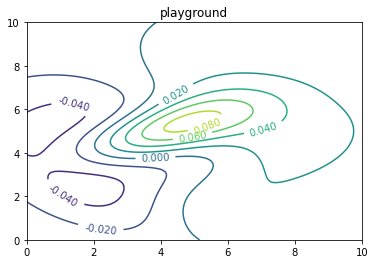

In [6]:
fig, ax = plt.subplots()
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
CS = ax.contour(X, Y, Z.T)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('playground')

On affiche au maximum 100 différentes ellipses que nous avons généré.

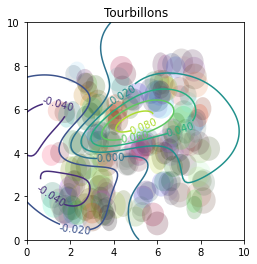

In [7]:
fig = plt.figure(0)
ax = fig.add_subplot(111, aspect='equal')
ax.set_ylim(0, 10)
ax.set_xlim(0, 10)
colors = np.random.rand(N,3)
CS = ax.contour(X, Y, Z.T)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Tourbillons')
for i in range(min(N,100)):
    tourbillon1 = plot_tourbillon(catalogue[i,0,:5])
    tourbillon2 = plot_tourbillon(catalogue[i,0,5:])
    ax.add_artist(tourbillon1)
    ax.add_artist(tourbillon2)
    color = colors[i]
    tourbillon1.set_facecolor(color)
    tourbillon2.set_facecolor(color*0.5)

# Prediction

In [8]:
true_values = list_true_value(catalogue, list_mean, list_covMat, N_pred, observations)
predictions = list_prediction(catalogue, N_pred, observations, method, nb_voisin)

On a donc généré pour les observations leurs véritable comportement (list_true_value) sur N_pred pas de temps à partir du playground.  
On a également généré les prédictions de notre méthode par rapport au catalogue original (predictions) selon la méthode choisie et le nombre de voisins

(0.0, 10.0)

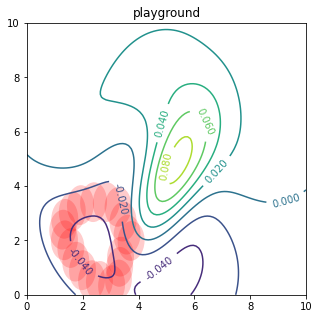

In [9]:
fig, ax = plt.subplots(figsize=(5,5))
ax = plot_trajectory(true_values[k], ax)
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('playground')
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)

On voit que le tourbillon suit bien les isolignes

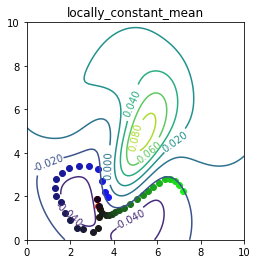

In [10]:
fig = plt.figure(0)
ax1 = fig.add_subplot(111, aspect='equal')
ax1.set_ylim(0, 10)
ax1.set_xlim(0, 10)
ax1.set_title(names[index])

CS = ax1.contour(X, Y, Z)
ax1.clabel(CS, inline=1, fontsize=10)
ax1.scatter(predictions[k,0,:5][0],predictions[k,0,:5][1],c=np.array([1,0.1,0]).reshape(1,-1))
ax1.scatter(predictions[k,0,5:][0],predictions[k,0,5:][1],c=np.array([1,0.1,0.]).reshape(1,-1))
pred = true_values[k]
true = predictions[k]
i = 0
for mean in pred:
    ax1.scatter(mean[0],mean[1],c = np.array([0.1,0.1,i/len(pred)]).reshape(1,-1))
    i+=1
i = 0
for mean in true:
    ax1.scatter(mean[0],mean[1],c = np.array([0.1,i/len(pred),0.1]).reshape(1,-1))
    i+=1

En bleu ce sont les prédictions et en vert ce sont les vrais valeurs. Plus la prédiction est lointaine plus la couleur est claire.  
On remarque que globalement nos prédictions sont cohérentes. Les prédictions peuvent parfois être erronées lorsque le tourbillon est à un point divergent.

# Calcul du RMSE et Wasserstein

Dans cette partie on va calculer le RMSE en fonction de l'horizon de prédiction

Text(0.5, 0, 'Temps')

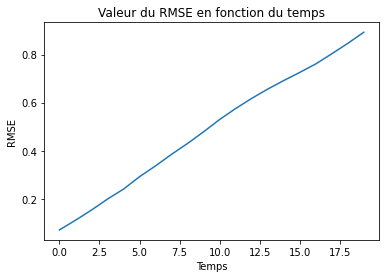

In [11]:
rmse = np.mean(AnDA_RMSE(predictions[:,:,5:],true_values),axis = 0)
plt.plot(rmse)
plt.title('Valeur du RMSE en fonction du temps')
plt.ylabel('RMSE')
plt.xlabel('Temps')

On remarque que plus la prédiction est lointaine, plus elle est incertaine. Cela est parfaitement logique.

In [12]:
print(f'Valeur du RMSE à la prédicion 8: {rmse[8]:.2f}')

Valeur du RMSE à la prédicion 8: 0.43


On réalise les mêmes tests mais cette fois en utilisant la metric Wasserstein pour comparer les tourbillons.

Text(0.5, 0, 'Temps')

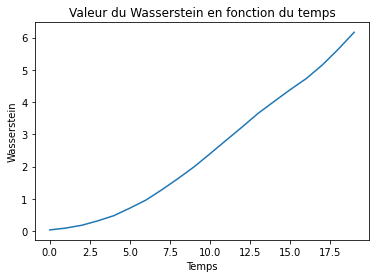

In [13]:
wasser = np.mean(AnDA_Wasserstein(predictions[:,:,5:],true_values),axis = 0)
plt.plot(wasser)
plt.title('Valeur du Wasserstein en fonction du temps')
plt.ylabel('Wasserstein')
plt.xlabel('Temps')

In [14]:
print(f'Valeur du Wasserstein à la prédicion 8: {wasser[8]:.2f}')

Valeur du Wasserstein à la prédicion 8: 1.63


# Influence des différentes hyperparamètres sur la prédiction

Maintenant nous allons comparer les 3 méthodes de prédiction afin de déterminer laquelle est la plus fiable.

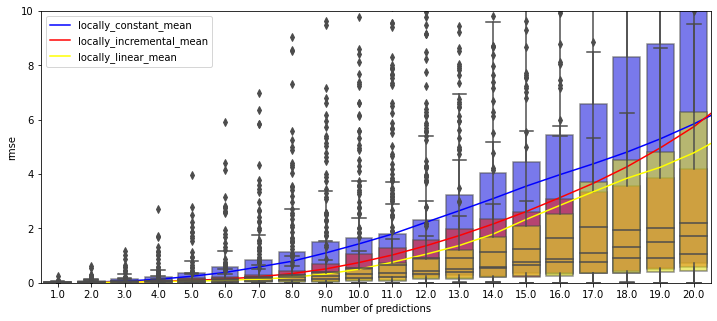

In [15]:
colors = ["blue", "red", "yellow"]

fig, ax = plt.subplots(figsize=(12,5))
ax.set_ylim(0, 10)

for i in range(len(names)):
    predictions = list_prediction(catalogue, N_pred, observations, methods[i], k=50)

    wasser = AnDA_Wasserstein(predictions[:,:,5:],true_values)
    time = np.arange(wasser.shape[1])+1
    times = np.stack([time]*wasser.shape[0], axis=0)
    wasser_times = np.stack([wasser, times], axis=-1)
    df = wasser_times.reshape((-1,2))
    wasser_df = pd.DataFrame(df, columns=["rmse", "number of predictions"])
    plt.plot(1+np.arange(wasser.shape[1]), wasser.mean(axis=0), color=colors[i], label=names[i])
    sns.boxplot(x="number of predictions", y="rmse", data=wasser_df, color=colors[i], ax=ax, boxprops=dict(alpha=.6))
plt.legend()

On a donc affiché des Boxplot et courbe de la Wasserstein Metric en fonction de l'horizon de prédiction et de la méthode. Dans ce graphe là nous avons fixé le nombre de voisins et la taille du catalogue.  
On peut remarquer que la méthode locally incremental mean est plus intéressante dans ce cas là.

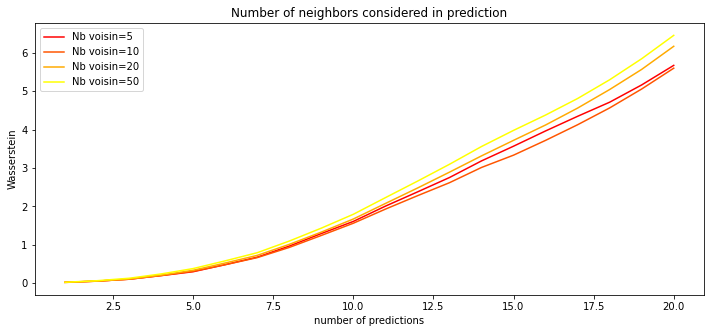

In [16]:
from matplotlib import cm

voisin = [5,10,20,50]
colors = cm.get_cmap("autumn")(np.linspace(0, 1, len(voisin)))
fig, ax = plt.subplots(figsize=(12,5))
ax.set_title("Number of neighbors considered in prediction")
ax.set_xlabel("number of predictions")
ax.set_ylabel("Wasserstein")

for i in range(len(voisin)):
    predictions = list_prediction(catalogue, N_pred, observations, method, voisin[i])
    predictions = predictions[:,:,5:]

    wasser = AnDA_Wasserstein(predictions,true_values)
    plt.plot(1+np.arange(wasser.shape[1]), wasser.mean(axis=0), color=colors[i], label="Nb voisin=%i"%(voisin[i]))
plt.legend()

Cette fois ci on fait varier le nombre de voisins choisi pour faire la prédiction. On observe que ce paramètre ne fait beaucoup varier les performances car les courbes sont quasiment superposés.

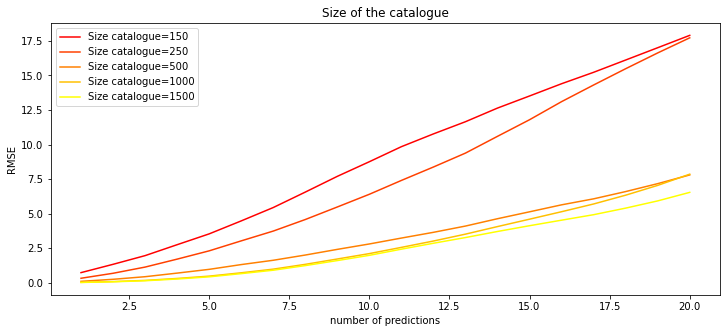

In [17]:
catalogue_size = [150,250,500,1000,1500]
colors = cm.get_cmap("autumn")(np.linspace(0, 1, len(catalogue_size)))
fig, ax = plt.subplots(figsize=(12,5))
ax.set_title("Size of the catalogue")
ax.set_xlabel("number of predictions")
ax.set_ylabel("RMSE")

for i in range(len(catalogue_size)):
    predictions = list_prediction(catalogue[:catalogue_size[i]], N_pred, observations, method, k=50)
    predictions = predictions[:,:,5:]

    wasser = AnDA_Wasserstein(predictions,true_values)
    plt.plot(np.arange(1,wasser.shape[1]+1), wasser.mean(axis=0), color=colors[i], label="Size catalogue=%i"%(catalogue_size[i]))
plt.legend()

On fait maintenant varier la taille du catalogue. Comme on peut s'y attendre on améliorer nos résultats en augmentant la taille du catalogue.